# 1. Import dependencies

In [1]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.5.7
charset-normalizer           3.2.0
click                        8.1.4
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
dm-tree                      0.1.8
etils                        1.3.0
executing                    1.2.0
flatbuffers                  23.5.26
fonttools                    4.40.0
gast                         0.5.4
google-auth                  2.21.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
googleapis-common-protos     1.56.4
grpcio                       1.56.0
h5py                         

In [3]:
!pip install tensorflow_datasets ipywidgets

In [2]:
# Bringing in tensorflow
import tensorflow as tf
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt

In [7]:
# Limit GPU memory growth:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.test.is_gpu_available(), tf.config.list_physical_devices('GPU')

(True, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [8]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-8d2571e5-e841-58d8-7d52-99ff2d58a8a2)


In [9]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\david\tensorflow_datasets\fashion_mnist\3.0.1.incompleteSGPSRK\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\david\tensorflow_datasets\fashion_mnist\3.0.1.incompleteSGPSRK\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\david\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [10]:
ds.as_numpy_iterator().next()['label']

2

In [22]:
ds # like a pipeline: repeat calls to retrieve more data

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# 2. Visualise data and build dataset

In [14]:
# Do some data transformation
import numpy as np

In [15]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [16]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

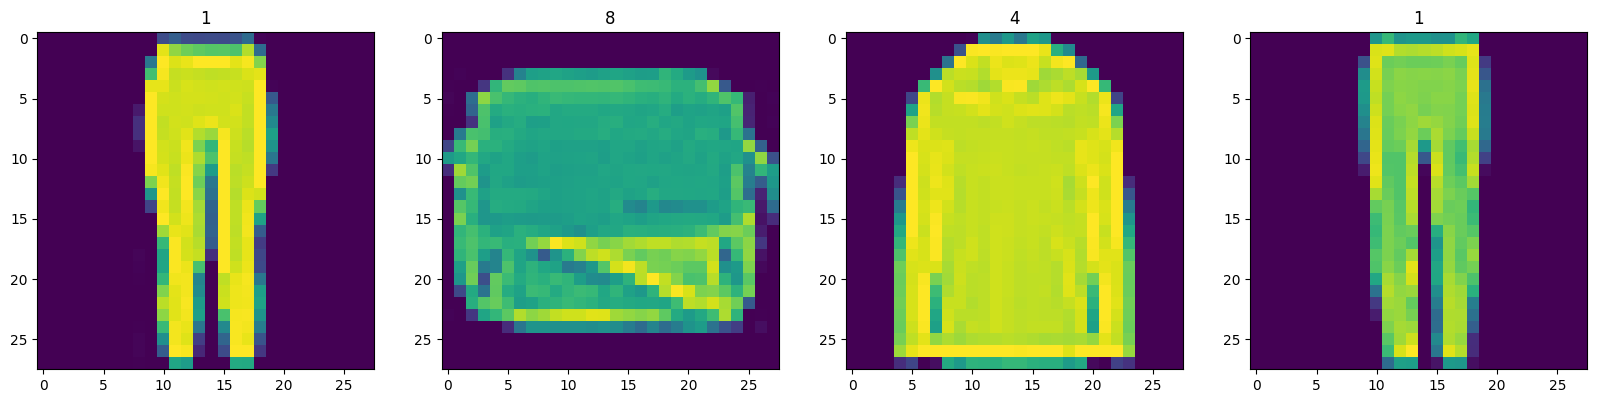

In [17]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image'])) # requires removing 1 dimension as it currently is (28, 28, 1), we want (28, 28)
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [18]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [19]:
# MCSHBAP
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up (60k samples https://www.tensorflow.org/datasets/catalog/fashion_mnist)
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [ ]:
# 60,000 images in batches of 128

In [20]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

## 3.1 Import modelling components

In [33]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## 3.2 Builed Generator

In [34]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128)) # generate based on 128 random values entered (latent space)
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1 (now 28x28x128)
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [35]:
generator = build_generator()

In [36]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [60]:
img = generator.predict(np.random.randn(4,128,1))

In [61]:
img.shape

(4, 28, 28, 1)

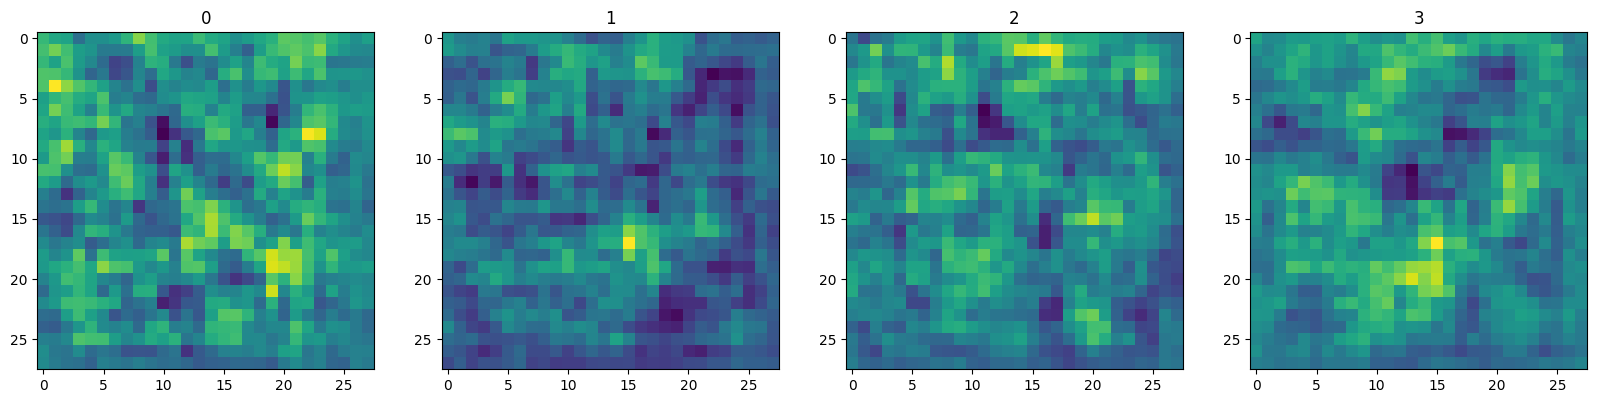

In [45]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

## 3.3 Build Discriminator

In [49]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1))) # 32 filters, 5x5 size, input_shape is same as the output of the generator
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [50]:
discriminator = build_discriminator()

In [51]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [64]:
img = img[0]

In [65]:
img.shape

(28, 28, 1)

In [66]:
discriminator.predict(np.expand_dims(img,0)) # has to be the batches of 4 from 61 above, else do what is here

array([[0.50700086]], dtype=float32)

# 4. Construct Training Loop

- Need to find a balance between the speed at which the dicriminator learns and generator trains for
    - we do this by adding random noise
- Takes a long time to train a DC-GAN

## 4.1 Setup optimizers and losses

In [67]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [70]:
g_opt = Adam(learning_rate=0.0001) # faster (10x) than discriminator to prevent discriminator learning too fast
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

## 4.2 Build subclassed model
- Requires a re-definition of what `.fit` does as the discriminator and genetaror have to learn independently

In [69]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [71]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels from the discriminator
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator (discrim gives 1 for fake image)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            # Implying the generated images are real images - reward generator for faking the discriminator (i.e. discrim predicts the generated image is real)
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [72]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [73]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## 4.3 Build Callbacks

In [75]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [78]:
# Save examples of the generated images as the model trains
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128): # number of images to save, how big latent dimension is
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## 4.3 Train
- recommend 2000 epochs

In [79]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 99s 200ms/step - d_loss: 0.5605 - g_loss: 0.8020
Epoch 2/20
469/469 [==============================] - 85s 181ms/step - d_loss: 0.3735 - g_loss: 5.2904
Epoch 3/20
469/469 [==============================] - 81s 172ms/step - d_loss: 0.6721 - g_loss: 0.6962
Epoch 4/20
469/469 [==============================] - 87s 186ms/step - d_loss: 0.5805 - g_loss: 0.3191
Epoch 5/20
469/469 [==============================] - 86s 184ms/step - d_loss: 0.3804 - g_loss: 0.0473
Epoch 6/20
469/469 [==============================] - 76s 163ms/step - d_loss: 0.5042 - g_loss: 0.1006
Epoch 7/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6567 - g_loss: 0.6068
Epoch 8/20
469/469 [==============================] - 77s 163ms/step - d_loss: 0.6912 - g_loss: 0.4714
Epoch 9/20
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6873 - g_loss: 0.5966
Epoch 10/20
469/469 [==============================] - 86s 184ms/step - d

## 4.4 Review Performance

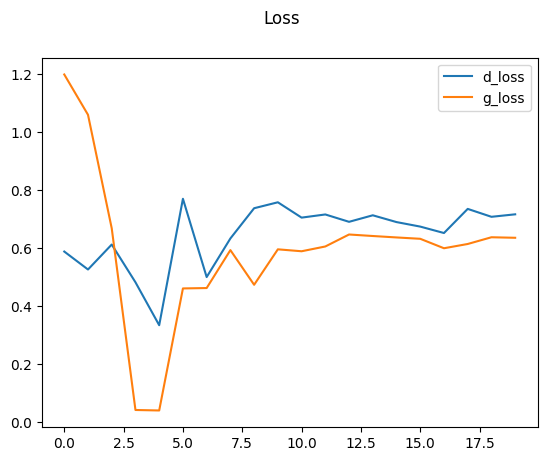

In [80]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test out the generator

## 5.1 Generate images

In [87]:
generator.load_weights(os.path.join('archive/generatormodel.h5'))

ValueError: axes don't match array

In [83]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

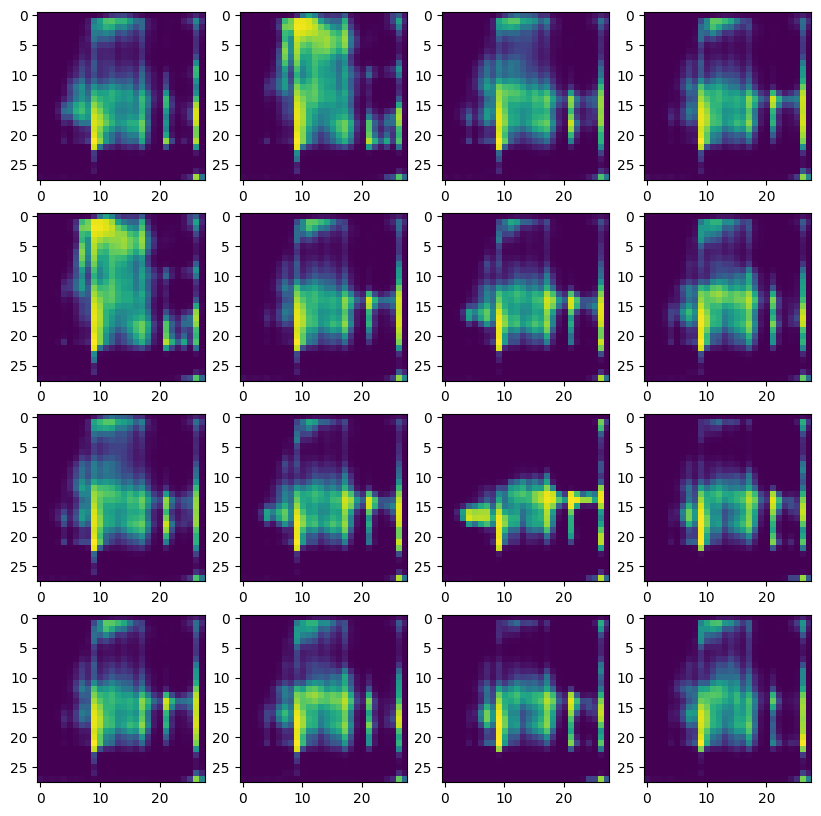

In [89]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

## 5.2 Save the model

In [88]:
generator.save('models/generator.h5')
discriminator.save('models/discriminator.h5')